**Step 1:Load Required Libraries**

In [5]:
#Install necessary Python packages required for scRNA-seq analysis.
!pip install scanpy anndata seaborn scikit-learn --quiet
!pip install torch-geometric -q

In [6]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set visualization style
sns.set_style("whitegrid")


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Load the dataset
file_path = '/content/drive/MyDrive/GSE155121_human_data_raw.h5ad'
# Load the dataset
adata = sc.read_h5ad(file_path)

# Show basic info
print(adata)
print("Dataset Loaded Successfully!")


AnnData object with n_obs × n_vars = 463304 × 32738
    obs: 'week_stage'
    var: 'gene_ids', 'feature_types-1-0-0-0-0-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0'
Dataset Loaded Successfully!


In [9]:
# Show all column names in cell-level metadata
adata.obs.columns.tolist()


['week_stage']

<ipython-input-10-7eb2ae852d5c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='week_stage', data=adata.obs, palette='Set2', dodge=False)


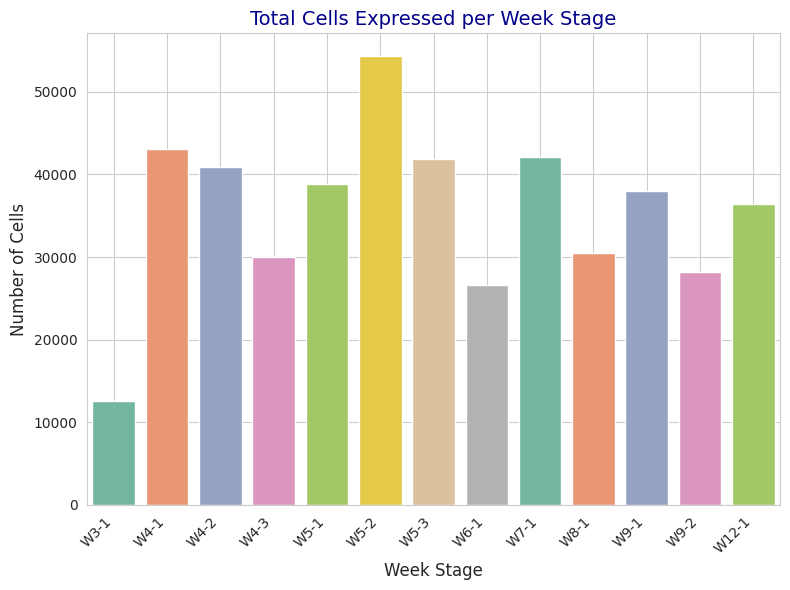

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'week_stage' is the correct column name
week_stage_counts = adata.obs['week_stage'].value_counts()

# Create a bar plot using seaborn (updated)
plt.figure(figsize=(8, 6))
# Use 'dodge=False' instead of legend=False to address the warning
ax = sns.countplot(x='week_stage', data=adata.obs, palette='Set2', dodge=False)
plt.title('Total Cells Expressed per Week Stage', fontsize=14, color='darkblue')
plt.xlabel('Week Stage', fontsize=12)
plt.ylabel('Number of Cells', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-11-b1987413bf6a>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=week_stage_gene_counts.index, y=week_stage_gene_counts.values, palette='Set2', dodge=False)


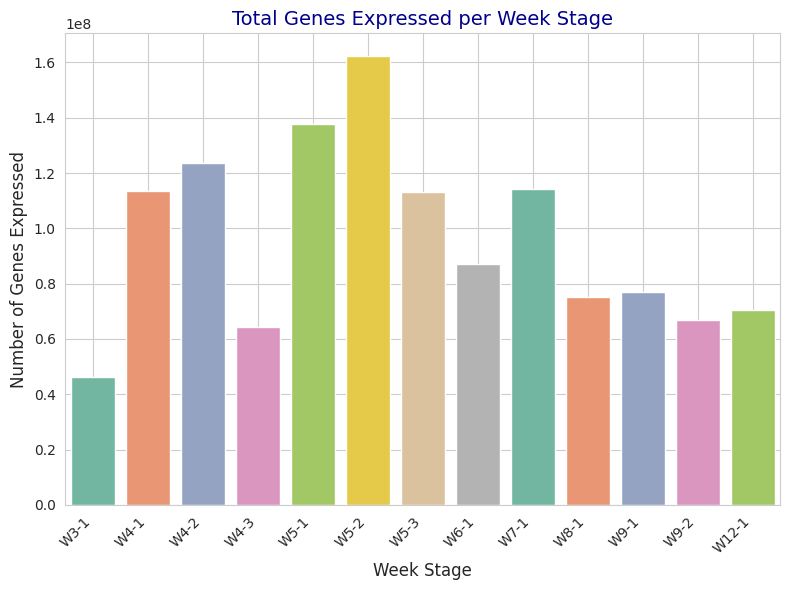

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the total number of genes expressed in each cell
adata.obs['n_genes_by_counts'] = (adata.X > 0).sum(axis=1)

# Calculate the total number of genes expressed in each week stage
# Added observed=False to suppress the FutureWarning
week_stage_gene_counts = adata.obs.groupby('week_stage', observed=False)['n_genes_by_counts'].sum()

# Create a bar plot
plt.figure(figsize=(8, 6))
# Set legend=False to suppress the FutureWarning (or assign hue and set legend=False)
ax = sns.barplot(x=week_stage_gene_counts.index, y=week_stage_gene_counts.values, palette='Set2', dodge=False)
plt.title('Total Genes Expressed per Week Stage', fontsize=14, color='darkblue')
plt.xlabel('Week Stage', fontsize=12)
plt.ylabel('Number of Genes Expressed', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# Summarizing dataset structure
print("Dataset Summary:")
print(f"Number of cells: {adata.n_obs}, Number of genes: {adata.n_vars}")
print("First few cell observations:")
display(adata.obs.head())
print("First few gene features:")
display(adata.var_names[:10])
print("Shape of raw dataset:", adata.X.shape)

# Check for missing values
# Convert adata.X to a dense NumPy array before checking for NaN
print("Total Missing Values in Dataset:", np.isnan(adata.X.toarray()).sum()) # The toarray() method converts a sparse matrix to a dense NumPy array.

Dataset Summary:
Number of cells: 463304, Number of genes: 32738
First few cell observations:


,week_stage,n_genes_by_counts
index,,
AAACCTGAGAATGTTG-1-0-0-0-0-0-0-0-0-0-0-0-0,W3-1,3476
AAACCTGAGCCAGAAC-1-0-0-0-0-0-0-0-0-0-0-0-0,W3-1,3880
AAACCTGAGGCAGTCA-1-0-0-0-0-0-0-0-0-0-0-0-0,W3-1,4646
AAACCTGAGGGATGGG-1-0-0-0-0-0-0-0-0-0-0-0-0,W3-1,4258
AAACCTGAGTGACATA-1-0-0-0-0-0-0-0-0-0-0-0-0,W3-1,3743


First few gene features:


Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10'],
      dtype='object', name='index')

Shape of raw dataset: (463304, 32738)
Total Missing Values in Dataset: 0


In [13]:
!pip install scikit-misc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 4.3 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


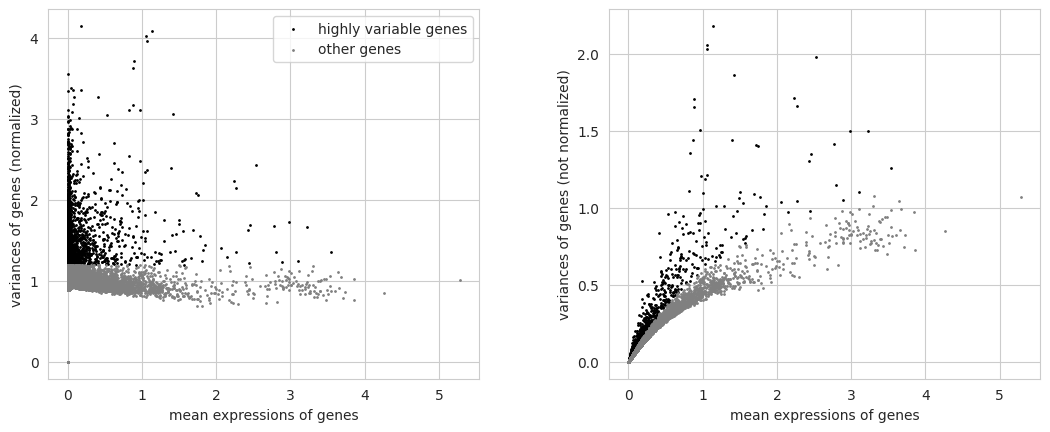

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
# Convert the sparse matrix to a dense array for the check
if np.any(adata.X.toarray() < 0):  # Log transformation should not have negative values
    print("Data is already log-transformed, skipping log1p step.")
else:
    sc.pp.log1p(adata)  # Apply log transformation only if needed

# Identifying Highly Variable Genes (Fixing Previous Error)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)  # Selects 2000 highly variable genes (HVGs) using the Seurat v3 method.
#These are genes that: Show high biological variation (not just noise) and are informative for clustering


# Visualizing highly variable genes
sc.pl.highly_variable_genes(adata)

# Filter only the highly variable genes
adata = adata[:, adata.var.highly_variable]  # Subsets your matrix to only HVGs — reducing data size and focusing on informative features.

# Scaling Data
sc.pp.scale(adata, max_value=10) # Standardizes each gene so they’re on the same scale for PCA or ML. Clipping extreme values to ±10 avoids outlier bias.


In [15]:
# Display dataset info
print(adata)
print("Data Preprocessing Completed!")

AnnData object with n_obs × n_vars = 463304 × 2000
    obs: 'week_stage', 'n_genes_by_counts'
    var: 'gene_ids', 'feature_types-1-0-0-0-0-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
Data Preprocessing Completed!


In [16]:
# Step 4: Exploratory Data Analysis (EDA)
# 1️⃣ Summary of Metadata
print("Available Metadata Columns:", adata.obs.columns)
print("Dataset Overview:")
print(adata.obs.head())


Available Metadata Columns: Index(['week_stage', 'n_genes_by_counts'], dtype='object')
Dataset Overview:
                                           week_stage  n_genes_by_counts
index                                                                   
AAACCTGAGAATGTTG-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1               3476
AAACCTGAGCCAGAAC-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1               3880
AAACCTGAGGCAGTCA-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1               4646
AAACCTGAGGGATGGG-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1               4258
AAACCTGAGTGACATA-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1               3743


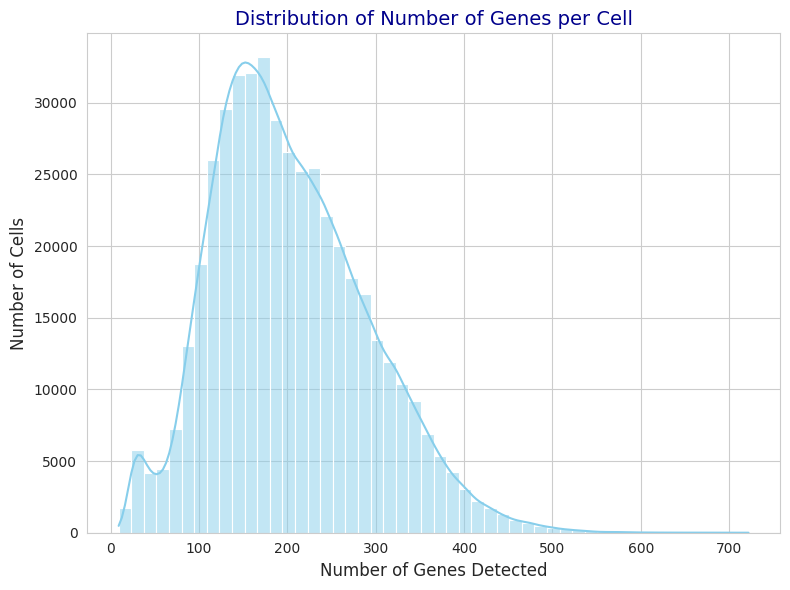

In [17]:
# Calculate the number of genes expressed in each cell
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1)

# Plot the distribution using seaborn for better visual quality
plt.figure(figsize=(8, 6))
sns.histplot(adata.obs['n_genes'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Number of Genes per Cell', fontsize=14, color='darkblue')
plt.xlabel('Number of Genes Detected', fontsize=12)
plt.ylabel('Number of Cells', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

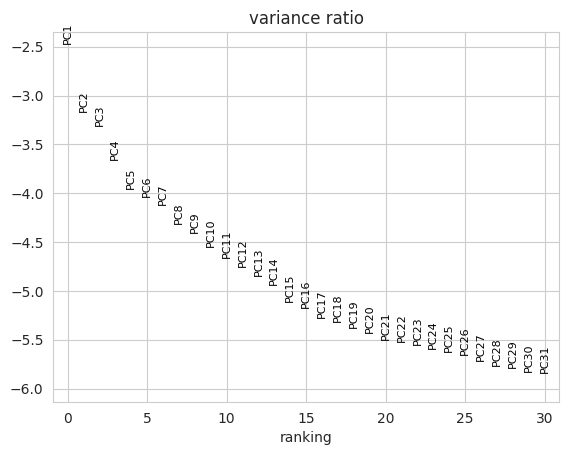

In [18]:
# 4️⃣ PCA for Dimensionality Reduction
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [19]:
sc.pp.neighbors(adata, n_pcs=20)


In [20]:
# Step 5: Construct Graph Representation
# Convert gene expression data into a graph structure

def build_gene_interaction_graph(adata):
    G = nx.Graph()
    genes = list(adata.var_names)

    # Add nodes (genes)
    for gene in genes:
        G.add_node(gene)

    # Define edges based on correlation (temporary method, can be replaced with known interactions)
    expression_matrix = adata.X.T  # Transpose to have genes as rows
    correlation_matrix = np.corrcoef(expression_matrix)

    threshold = 0.7  # Adjust for significant correlations
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            if correlation_matrix[i, j] > threshold:
                G.add_edge(genes[i], genes[j], weight=correlation_matrix[i, j])

    return G

In [21]:
# Build graph
gene_graph = build_gene_interaction_graph(adata)
print(f"Graph constructed with {gene_graph.number_of_nodes()} nodes and {gene_graph.number_of_edges()} edges.")

Graph constructed with 2000 nodes and 519 edges.


In [22]:
# Step 6: Convert Graph to PyTorch Geometric Format

def convert_to_pyg_data(graph):
    node_index = {node: i for i, node in enumerate(graph.nodes())}
    edge_index = []
    edge_attr = []

    for u, v, data in graph.edges(data=True):
        edge_index.append([node_index[u], node_index[v]])
        edge_attr.append(data['weight'])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Convert gene expression data into PyTorch tensor
    x = torch.tensor(adata.X, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

In [23]:
# Convert to PyTorch Geometric format
gene_graph_data = convert_to_pyg_data(gene_graph)
print("Graph successfully converted to PyTorch Geometric format!")

Graph successfully converted to PyTorch Geometric format!


In [24]:
# Step 7: Implement Graph Attention Network (GAT)
class GATModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=3):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [25]:
# Define Model Parameters
input_dim = gene_graph_data.x.shape[1]
hidden_dim = 64
output_dim = len(set(adata.obs['week_stage']))  # Assuming week_stage as target labels

In [26]:
import torch.optim as optim

In [27]:
# Initialize Model
gat_model = GATModel(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

In [28]:
import torch.nn.functional as F

In [29]:
from sklearn.preprocessing import LabelEncoder

“Which gene expressions help me tell week 4 vs week 8 cells apart?” (cell-based)

In [30]:
# Step 8: Train GAT Model with Training & Validation Splitting
def train_model(model, data, epochs=25, patience=10):
    model.train()
    encoder = LabelEncoder()

    if 'week_stage_encoded' not in adata.obs.columns:
        adata.obs['week_stage_encoded'] = encoder.fit_transform(adata.obs['week_stage'])

    # Split indices into training (80%) and validation (20%)
    indices = np.arange(len(adata))
    np.random.shuffle(indices)
    split_idx = int(0.8 * len(indices))
    train_indices, val_indices = indices[:split_idx], indices[split_idx:]

    # Split the dataset into training and validation sets
    train_x = data.x[train_indices]
    val_x = data.x[val_indices]

    train_labels = torch.tensor(adata.obs['week_stage_encoded'].values[train_indices], dtype=torch.long)
    val_labels = torch.tensor(adata.obs['week_stage_encoded'].values[val_indices], dtype=torch.long)

    best_loss = float('inf')
    epochs_without_improvement = 0
    loss_history, accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(Data(x=train_x, edge_index=data.edge_index, edge_attr=data.edge_attr))
        loss = criterion(out, train_labels)
        loss.backward()
        optimizer.step()

        # Store training loss & accuracy
        loss_history.append(loss.item())
        train_preds = out.argmax(dim=1).detach().cpu().numpy()
        train_acc = accuracy_score(train_labels.cpu().numpy(), train_preds)
        accuracy_history.append(train_acc)

        # Validation step
        model.eval()
        with torch.no_grad():
            val_out = model(Data(x=val_x, edge_index=data.edge_index, edge_attr=data.edge_attr))
            val_loss = criterion(val_out, val_labels)
            val_loss_history.append(val_loss.item())
            val_preds = val_out.argmax(dim=1).cpu().numpy()
            val_acc = accuracy_score(val_labels.cpu().numpy(), val_preds)
            val_accuracy_history.append(val_acc)
        model.train()

        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 5 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.3f}, Accuracy: {train_acc:.3f}, Val Loss: {val_loss.item():.3f}, Val Accuracy: {val_acc:.3f}")

    return loss_history, accuracy_history, val_loss_history, val_accuracy_history

# Train the model
loss_history, accuracy_history, val_loss_history, val_accuracy_history = train_model(gat_model, gene_graph_data)


Epoch 0, Loss: 3.286, Accuracy: 0.054, Val Loss: 3.640, Val Accuracy: 0.420
Epoch 5, Loss: 0.999, Accuracy: 0.791, Val Loss: 1.027, Val Accuracy: 0.806
Epoch 10, Loss: 0.370, Accuracy: 0.906, Val Loss: 0.361, Val Accuracy: 0.910
Epoch 15, Loss: 0.240, Accuracy: 0.931, Val Loss: 0.219, Val Accuracy: 0.939
Epoch 20, Loss: 0.183, Accuracy: 0.946, Val Loss: 0.197, Val Accuracy: 0.946


In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_loss_curve(loss_history, val_loss_history, save_path=None):
    plt.figure(figsize=(6, 6))
    plt.plot(loss_history, label="Training Loss", color='tomato', linewidth=2)
    plt.plot(val_loss_history, label="Validation Loss", color='dodgerblue', linestyle='--', linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training vs Validation Loss", fontsize=14, weight='bold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


def plot_accuracy_curve(accuracy_history, val_accuracy_history, save_path=None):
    plt.figure(figsize=(6, 6))
    plt.plot(accuracy_history, label="Training Accuracy", color='seagreen', linewidth=2)
    plt.plot(val_accuracy_history, label="Validation Accuracy", color='darkorange', linestyle='--', linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Training vs Validation Accuracy", fontsize=14, weight='bold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


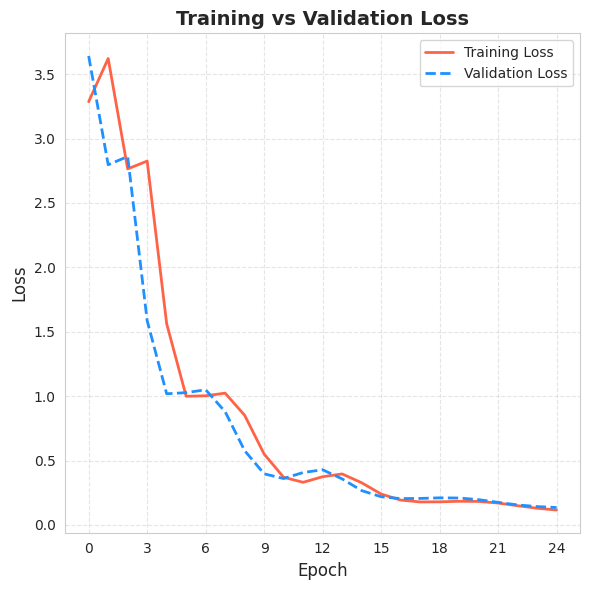

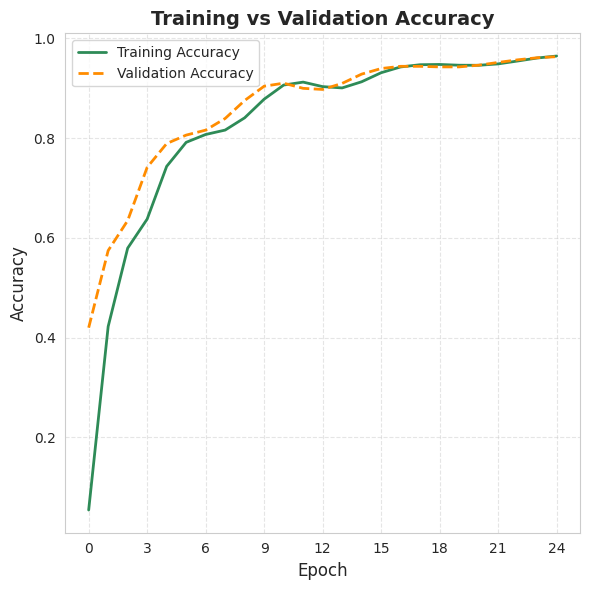

In [32]:
plot_loss_curve(loss_history, val_loss_history)
plot_accuracy_curve(accuracy_history, val_accuracy_history)


In [33]:
# Get true labels for the entire dataset
true_labels = adata.obs['week_stage_encoded'].values

# Get predictions for the entire dataset
gat_model.eval()  # Set model to evaluation mode
with torch.no_grad():
    all_out = gat_model(gene_graph_data)  # Pass the entire graph data
    predictions = all_out.argmax(dim=1).cpu().numpy()

In [34]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_loss_curve(loss_history, val_loss_history, save_path=None):
    plt.figure(figsize=(6, 6))
    plt.plot(loss_history, label="Training Loss", color='tomato', linewidth=2)
    plt.plot(val_loss_history, label="Validation Loss", color='dodgerblue', linestyle='--', linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training vs Validation Loss", fontsize=14, weight='bold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


def plot_accuracy_curve(accuracy_history, val_accuracy_history, save_path=None):
    plt.figure(figsize=(6, 6))
    plt.plot(accuracy_history, label="Training Accuracy", color='seagreen', linewidth=2)
    plt.plot(val_accuracy_history, label="Validation Accuracy", color='darkorange', linestyle='--', linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Training vs Validation Accuracy", fontsize=14, weight='bold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


In [35]:
# Compute Accuracy
acc = accuracy_score(true_labels, predictions)
print(f"Model Accuracy: {acc:.4f}")

Model Accuracy: 0.9665


In [36]:
# Classification Report
print("Classification Report:\n", classification_report(true_labels, predictions))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.94     36368
           1       0.99      1.00      0.99     12530
           2       0.99      0.99      0.99     43086
           3       0.95      0.96      0.95     40878
           4       0.99      0.99      0.99     30038
           5       0.99      0.99      0.99     38833
           6       0.98      0.99      0.99     54352
           7       0.99      0.99      0.99     41811
           8       0.96      0.98      0.97     26610
           9       0.94      0.93      0.94     42080
          10       0.95      0.95      0.95     30495
          11       0.94      0.96      0.95     38004
          12       0.91      0.95      0.93     28219

    accuracy                           0.97    463304
   macro avg       0.97      0.97      0.97    463304
weighted avg       0.97      0.97      0.97    463304



In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(true_labels, predictions, class_names=None, normalize=False, title='Confusion Matrix - GAT'):
    cm = confusion_matrix(true_labels, predictions, normalize='true' if normalize else None)
    acc = accuracy_score(true_labels, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', linewidths=0.5, square=True,
                xticklabels=class_names if class_names else 'auto',
                yticklabels=class_names if class_names else 'auto')

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    # Setting the title using the 'title' parameter
    plt.title(title, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()


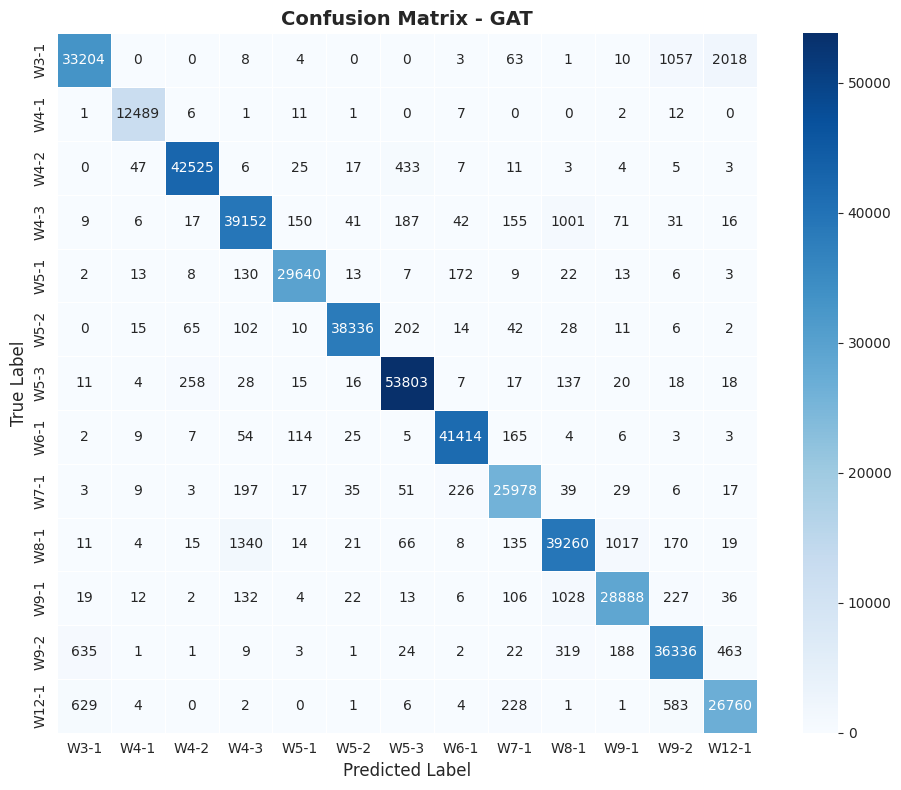

In [38]:
# Plot it
# Get the unique week stages from your data and use them as class names
class_names = adata.obs['week_stage'].unique()
plot_confusion_matrix(true_labels, predictions, class_names=class_names)

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [40]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_multiclass_roc(gat_model, graph_data, true_labels, class_names=None):
    # Evaluate GAT model
    gat_model.eval()
    with torch.no_grad():
        out = gat_model(graph_data)
        probs = torch.exp(out).cpu().numpy()
        preds = out.argmax(dim=1).cpu().numpy()

    n_classes = probs.shape[1]
    y_bin = label_binarize(true_labels, classes=np.arange(n_classes))

    # Compute ROC curve and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot setup
    plt.figure(figsize=(6, 6))
    colors = cycle([
        'aqua', 'darkorange', 'cornflowerblue', 'green', 'red',
        'purple', 'brown', 'olive', 'gold', 'black', 'pink', 'slategray'
    ])

    for i, color in zip(range(n_classes), colors):
        label = class_names[i] if class_names is not None else f"Class {i}"
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{label} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('GAT Model ROC Curve (Multiclass)', fontsize=14, weight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


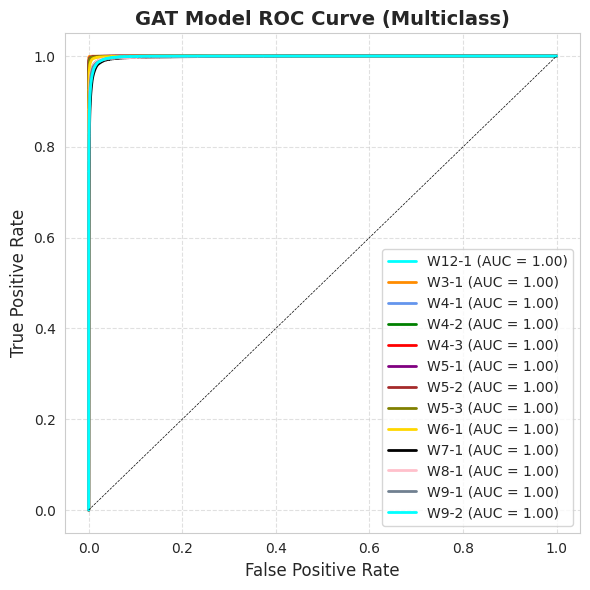

In [41]:
# Use class names from LabelEncoder if available
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
encoder = LabelEncoder()
encoder.fit(adata.obs['week_stage'])
class_names = encoder.classes_
true_labels = adata.obs['week_stage_encoded'].values

plot_multiclass_roc(gat_model, gene_graph_data, true_labels, class_names=class_names)


Top 50 Most Important Genes:
              Gene  Importance
92            CD53    1.000000
130          CKS1B    0.986083
535           GYPB    0.884521
6             ENO1    0.877645
26            C1QC    0.760307
457          CRMP1    0.553974
155         FCER1G    0.536126
329         EEF1B2    0.516959
1165          HBG1    0.490177
377         CX3CR1    0.470634
899          GPR34    0.469192
1988        MT-ND1    0.468286
25            C1QA    0.468256
402          GAP43    0.444013
1990        MT-CO2    0.441505
825   RP11-797H7.5    0.429092
59          ELAVL4    0.414567
190           ASPM    0.397057
157            MPZ    0.388515
657         TUBB2A    0.385442
1324          KRT8    0.376402
110         MLLT11    0.359492
879       TMEM176B    0.356203
912           CDX4    0.347216
28             ID3    0.346494
550          HMGB2    0.321481
639          PTTG1    0.302111
536           GYPA    0.293787
1310        TUBA1B    0.292016
534           GYPE    0.291621
815       

<ipython-input-42-a9684c036525>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


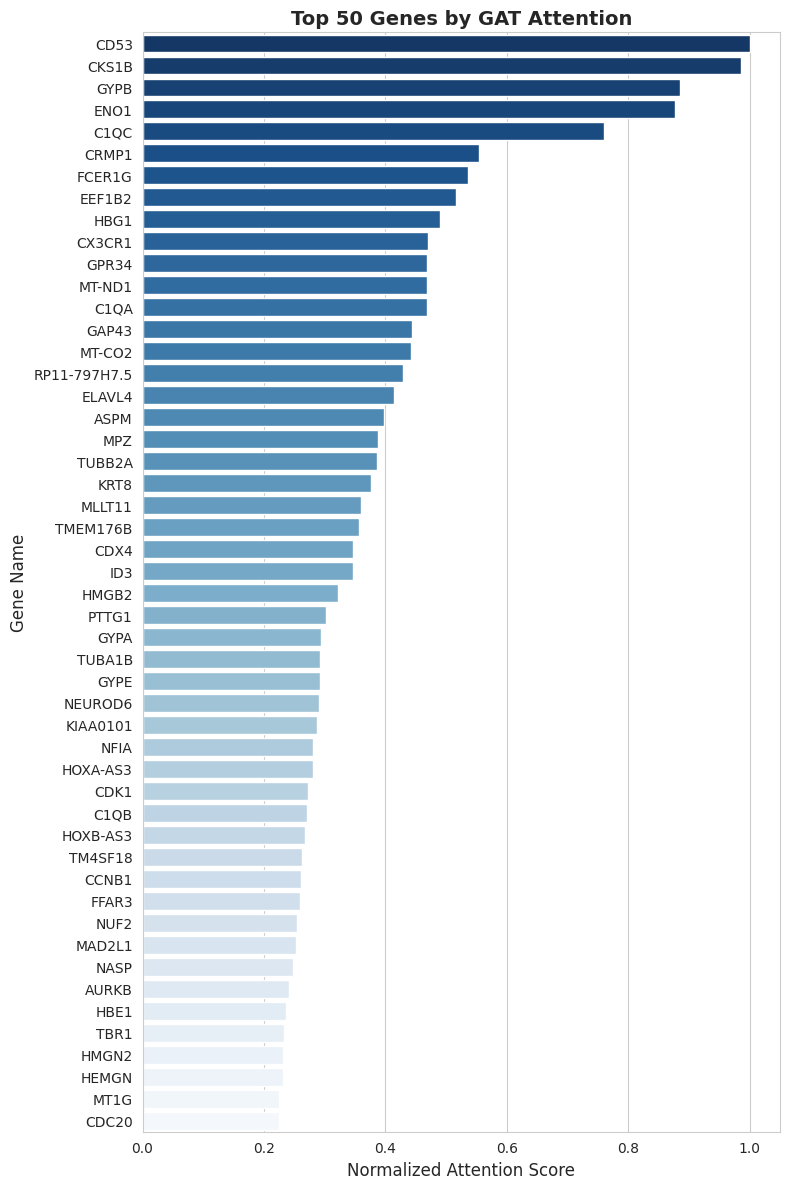

In [42]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to extract attention weights from GAT
def extract_attention_weights(model, data):
    model.eval()
    with torch.no_grad():
        _, (edge_index, attention_weights) = model.conv1(data.x, data.edge_index, return_attention_weights=True)

    return edge_index.cpu().numpy(), attention_weights.cpu().numpy()

# Extract attention weights
edge_index, attention_weights = extract_attention_weights(gat_model, gene_graph_data)

# If multi-head attention, average over heads
if attention_weights.ndim == 2:  # Shape (num_edges, num_heads)
    attention_weights = np.mean(attention_weights, axis=1)  # Take mean across heads

# Aggregate attention scores per **gene** (not per node)
gene_names = list(adata.var_names)  # 2000 genes
gene_importance = np.zeros(len(gene_names))

# Map node indices to genes
node_to_gene_map = adata.var_names.to_list()  # Ensure genes are correctly mapped

for i in range(edge_index.shape[1]):
    source = edge_index[0, i]  # Source node index
    if source < len(gene_names):  # Ensure mapping only within gene list
        weight = attention_weights[i]
        gene_importance[source] += weight  # Sum attention scores per gene

# Normalize importance scores
gene_importance /= np.max(gene_importance)  # Normalize to range [0, 1]

# Create DataFrame with gene names and importance
gene_importance_df = pd.DataFrame({"Gene": gene_names, "Importance": gene_importance})
gene_importance_df = gene_importance_df.sort_values(by="Importance", ascending=False)

# Display top 50 most important genes
print("Top 50 Most Important Genes:")
print(gene_importance_df.head(50))
import seaborn as sns

plt.figure(figsize=(8, 12))
sns.barplot(
    x="Importance", y="Gene",
    data=gene_importance_df.head(50),
    palette="Blues_r"
)
plt.title("Top 50 Genes by GAT Attention", fontsize=14, weight='bold')
plt.xlabel("Normalized Attention Score", fontsize=12)
plt.ylabel("Gene Name", fontsize=12)
plt.tight_layout()
plt.show()


In [43]:
import pandas as pd
import torch

# Get unique weeks
unique_weeks = adata.obs['week_stage'].unique()

# Dictionary to store results
top_genes_per_week = {}

# Iterate through each week
for week in unique_weeks:
    print(f"Processing Week: {week}")

    # Subset data for the current week
    week_mask = adata.obs['week_stage'] == week

    # Create a new Data object with the subsetted data and original graph structure
    week_data = Data(x=gene_graph_data.x[week_mask],
                     edge_index=gene_graph_data.edge_index,
                     edge_attr=gene_graph_data.edge_attr)

    # Get attention scores for this week
    with torch.no_grad():
        gat_output = gat_model(week_data)  # Run GAT on the week's data

        # Get attention weights from the first GATConv layer
        _, (edge_index, attention_weights) = gat_model.conv1(week_data.x, week_data.edge_index, return_attention_weights=True)
        attention_weights = attention_weights.cpu().numpy()

        # If multi-head attention, average over heads
        if attention_weights.ndim == 2:  # Shape (num_edges, num_heads)
            attention_weights = np.mean(attention_weights, axis=1)  # Take mean across heads

        # Aggregate attention scores per gene
        gene_importance = np.zeros(len(adata.var_names))
        for i in range(edge_index.shape[1]):
            source = edge_index[0, i].item()  # Get source node index as an integer
            if source < len(adata.var_names):
                gene_importance[source] += attention_weights[i]

        # Normalize importance scores
        gene_importance /= np.max(gene_importance) if np.max(gene_importance) != 0 else 1  # Avoid division by zero


    # Create DataFrame of genes and importance
    gene_importance_df = pd.DataFrame({
        "Gene": adata.var_names,
        "Importance": gene_importance
    })

    # Sort and select top 20
    gene_importance_df = gene_importance_df.sort_values(by="Importance", ascending=False).head(20)

    # Store results
    top_genes_per_week[week] = gene_importance_df

# Display results
for week, df in top_genes_per_week.items():
    print(f"\nTop 20 Genes for Week {week}")
    print(df)

Processing Week: W3-1


<ipython-input-43-ac1088f67c33>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  week_data = Data(x=gene_graph_data.x[week_mask],


Processing Week: W4-1
Processing Week: W4-2
Processing Week: W4-3
Processing Week: W5-1
Processing Week: W5-2
Processing Week: W5-3
Processing Week: W6-1
Processing Week: W7-1
Processing Week: W8-1
Processing Week: W9-1
Processing Week: W9-2
Processing Week: W12-1

Top 20 Genes for Week W3-1
              Gene  Importance
92            CD53    1.000000
130          CKS1B    0.986083
535           GYPB    0.884521
6             ENO1    0.877645
26            C1QC    0.760307
457          CRMP1    0.553974
155         FCER1G    0.536126
329         EEF1B2    0.516959
1165          HBG1    0.490177
377         CX3CR1    0.470634
899          GPR34    0.469192
1988        MT-ND1    0.468286
25            C1QA    0.468256
402          GAP43    0.444013
1990        MT-CO2    0.441505
825   RP11-797H7.5    0.429092
59          ELAVL4    0.414567
190           ASPM    0.397057
157            MPZ    0.388515
657         TUBB2A    0.385442

Top 20 Genes for Week W4-1
              Gene  Importan

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_genes_bar(top_genes_per_week):
    sns.set(style="whitegrid")

    for week, df in top_genes_per_week.items():
        df_sorted = df.sort_values(by="Importance", ascending=False)  # Sort largest first

        plt.figure(figsize=(10, 6))
        sns.barplot(
            x="Importance",
            y="Gene",
            data=df_sorted,  # Use sorted DataFrame
            palette="Blues_r"
        )
        plt.xlabel("Normalized Attention Score", fontsize=12)
        plt.ylabel("Gene Name", fontsize=12)
        plt.title(f"Top 20 Genes in {week} Based on GAT Attention Scores", fontsize=14, weight='bold')
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


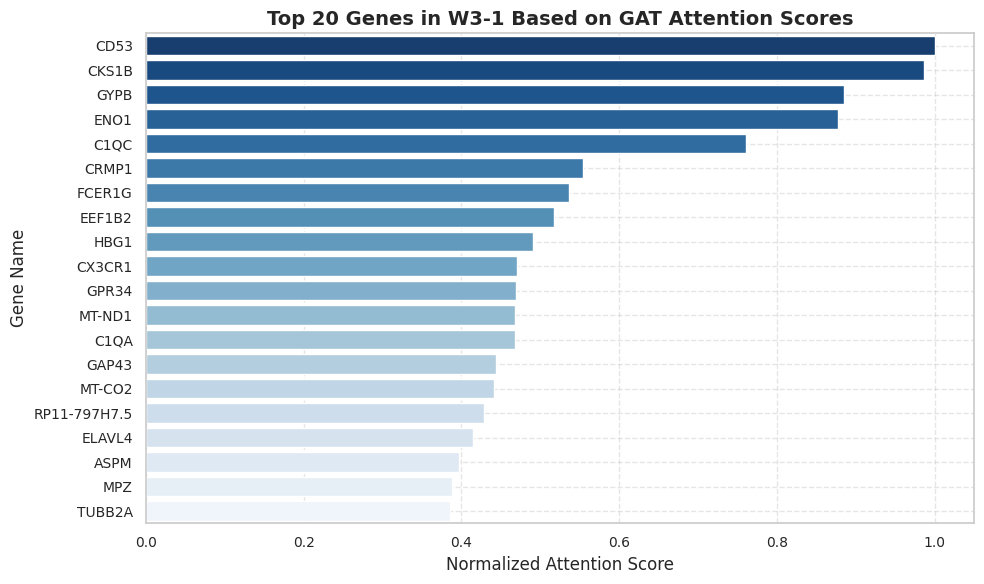

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


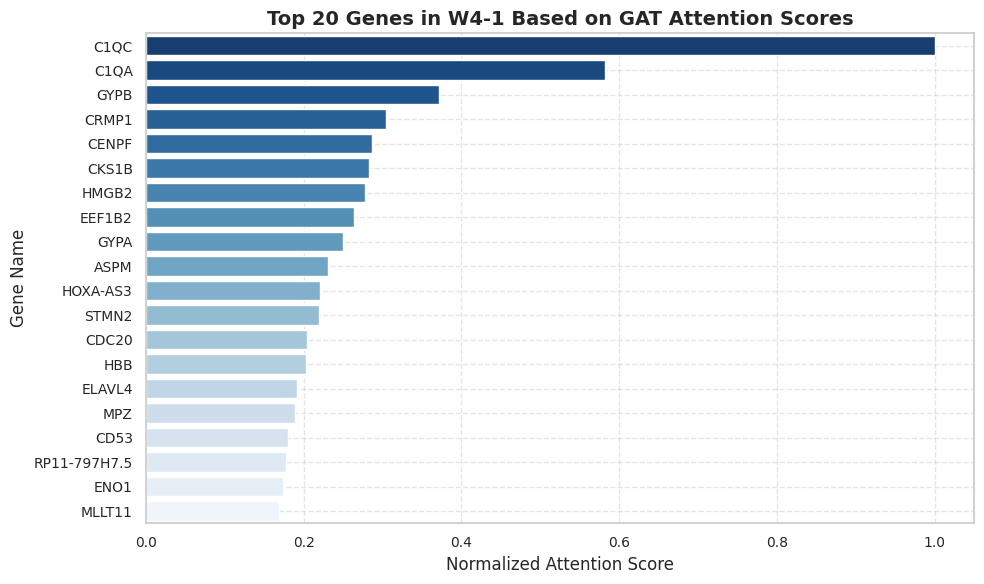

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


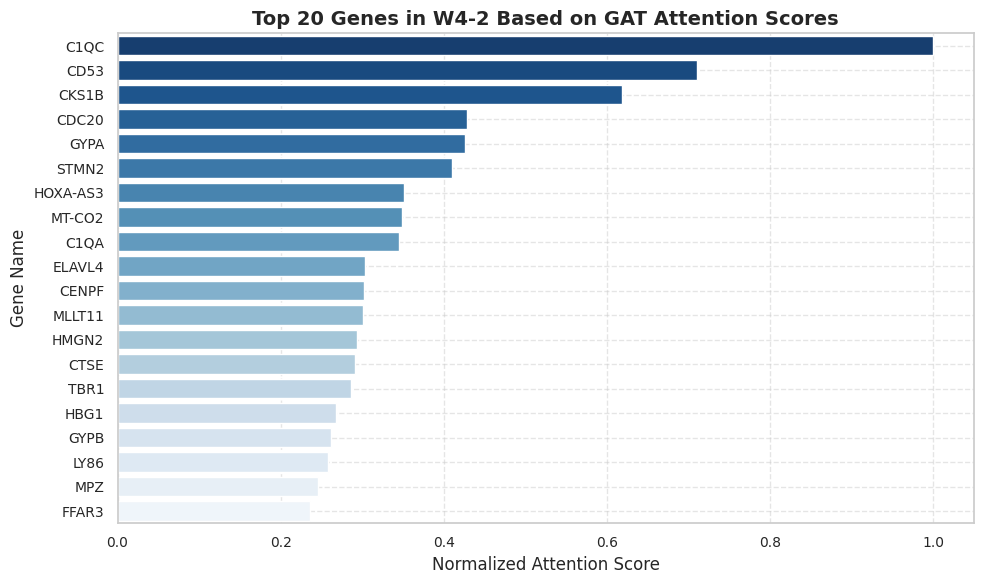

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


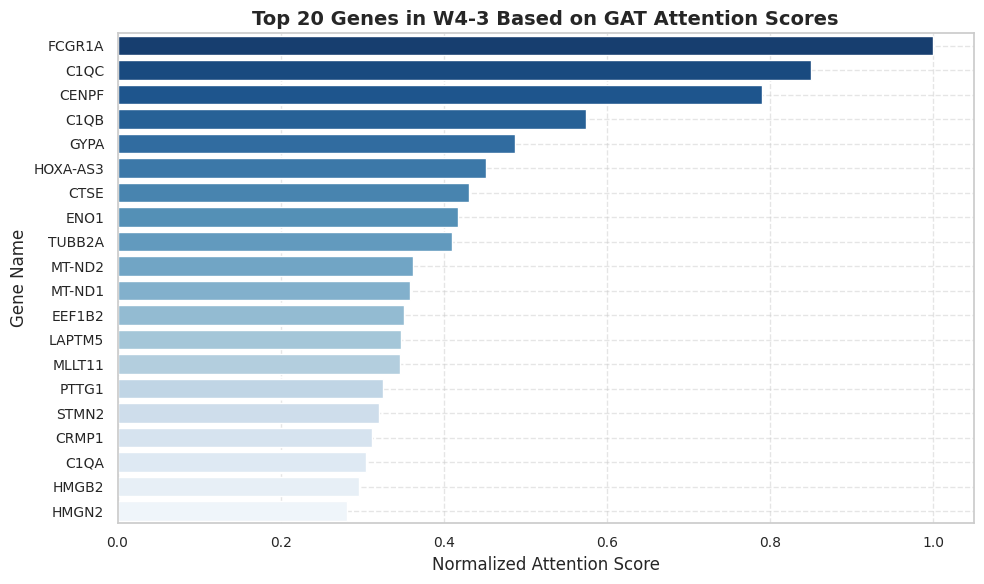

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


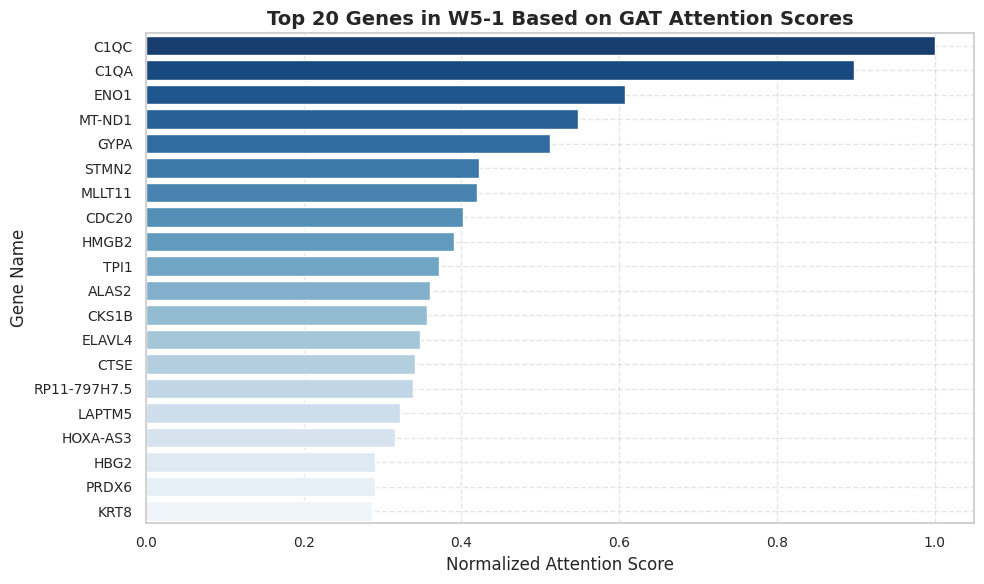

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


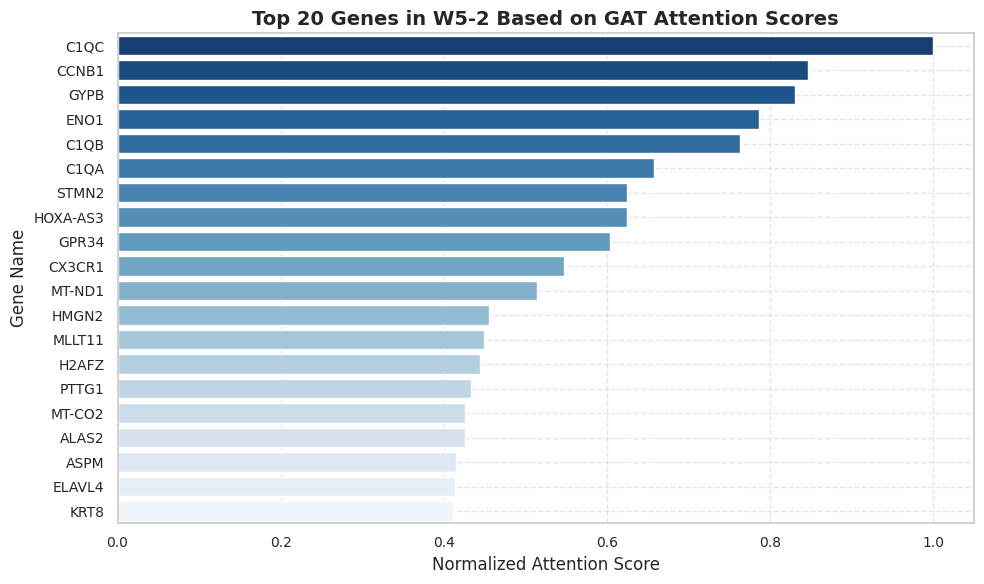

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


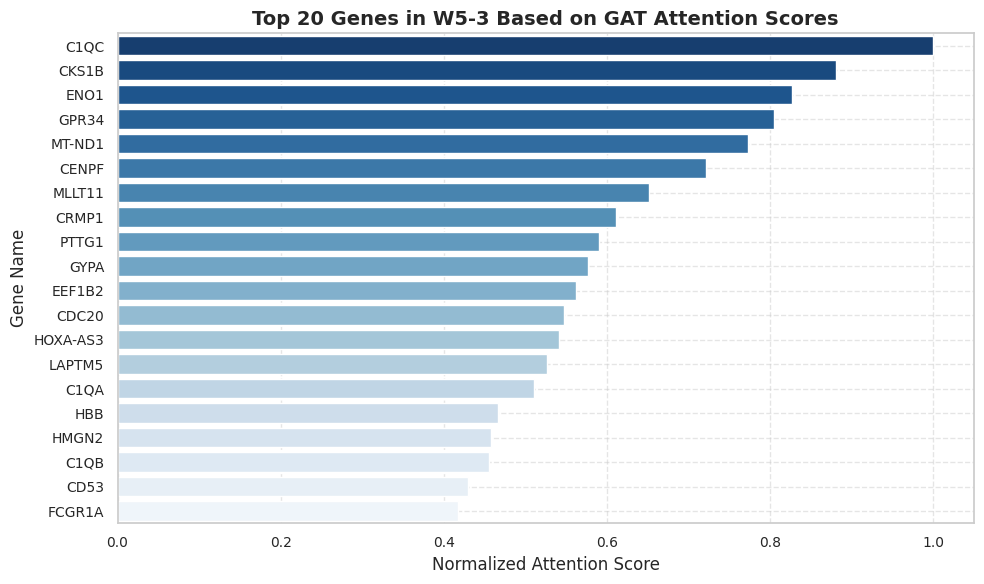

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


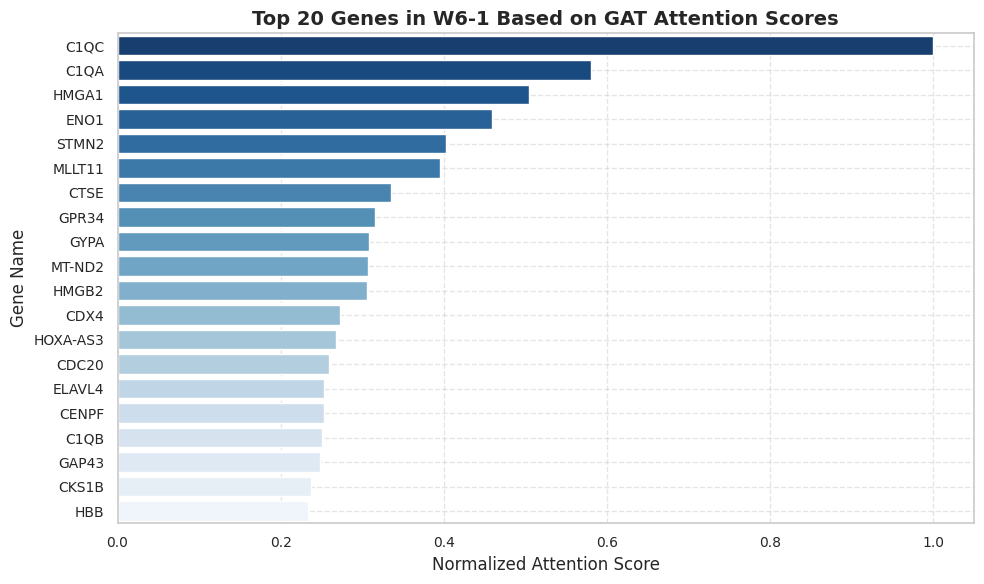

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


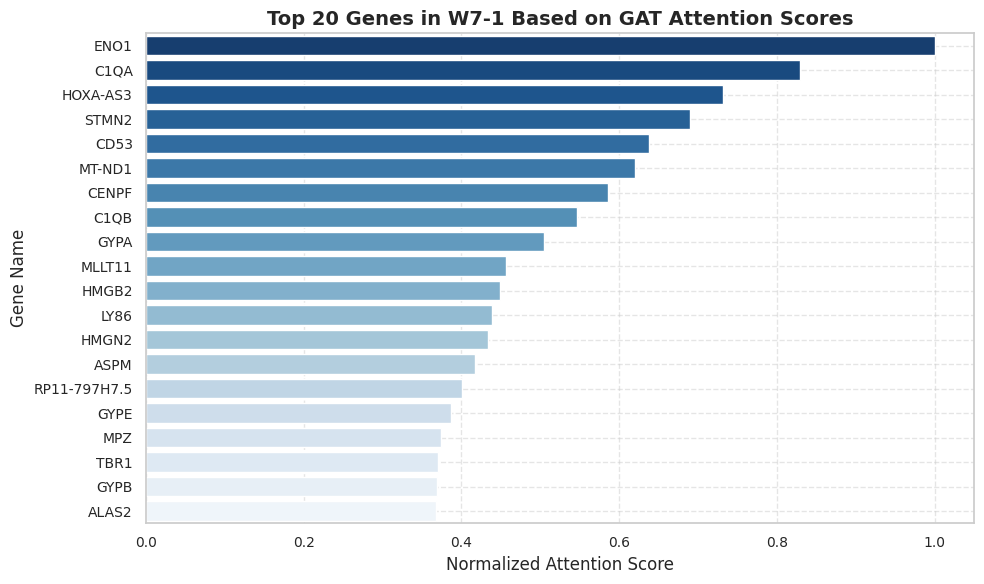

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


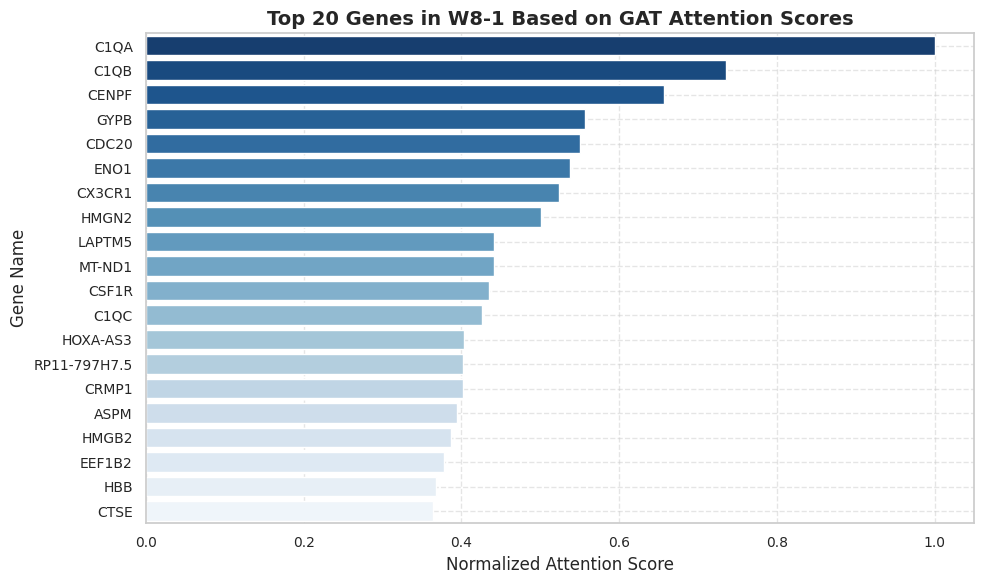

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


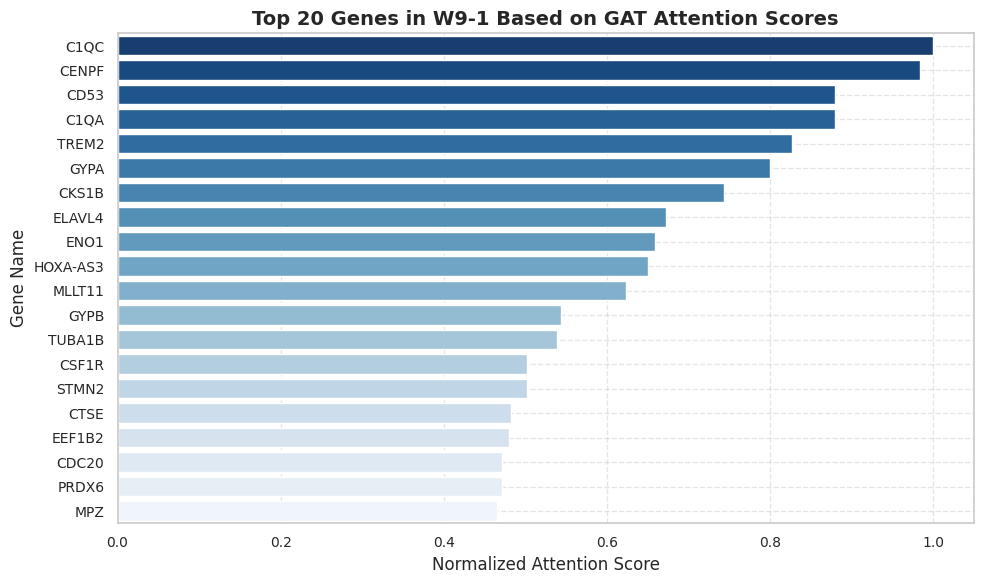

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


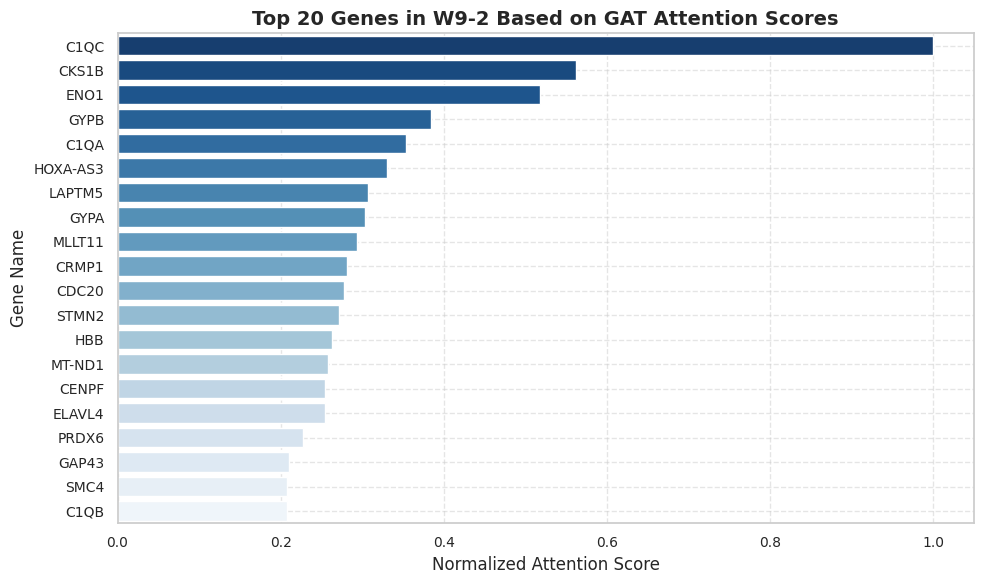

<ipython-input-44-5c4296b23c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


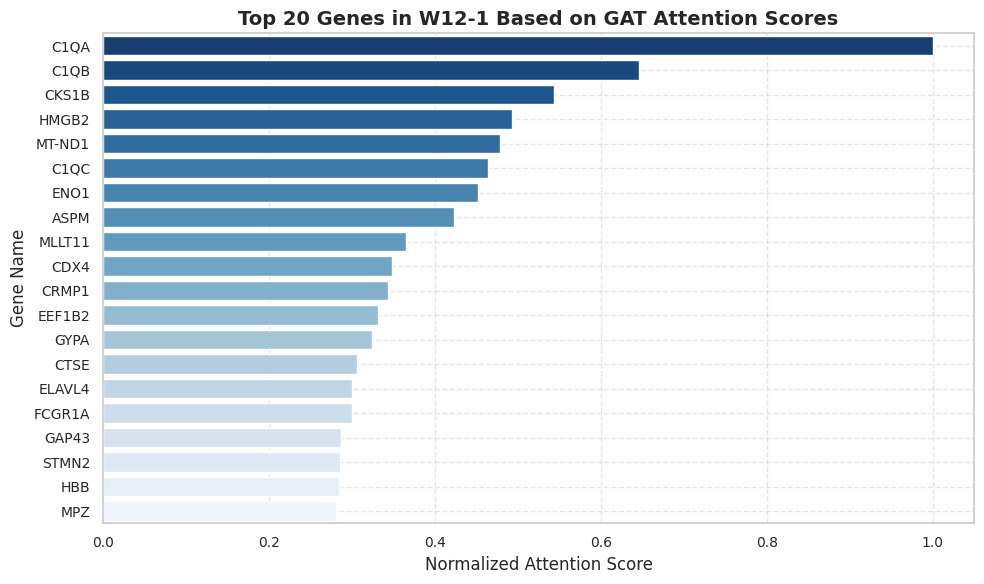

In [45]:
plot_top_genes_bar(top_genes_per_week)


In [46]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(graph_data, node_size=15, edge_alpha=0.3):
    # Convert PyTorch Geometric data to NetworkX
    G = nx.Graph()

    edge_index = graph_data.edge_index.cpu().numpy()
    G.add_edges_from(zip(edge_index[0], edge_index[1]))

    # Layout
    pos = nx.spring_layout(G, seed=42)  # Stable layout, reproducible

    # Plot
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_edges(G, pos, alpha=edge_alpha)
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color="blue", alpha=0.7)

    plt.title("Gene Interaction Graph Used for GAT Input", fontsize=14, weight="bold")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


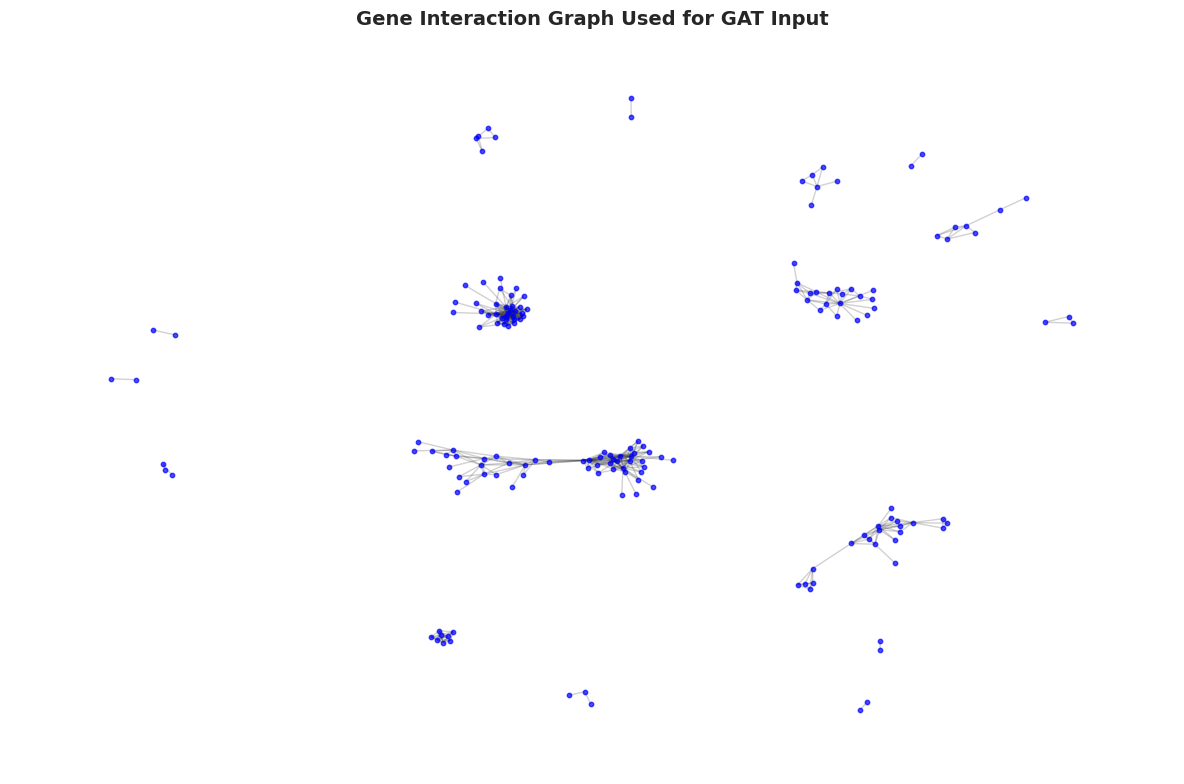

In [47]:
visualize_graph(gene_graph_data, node_size=10, edge_alpha=0.2)



/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


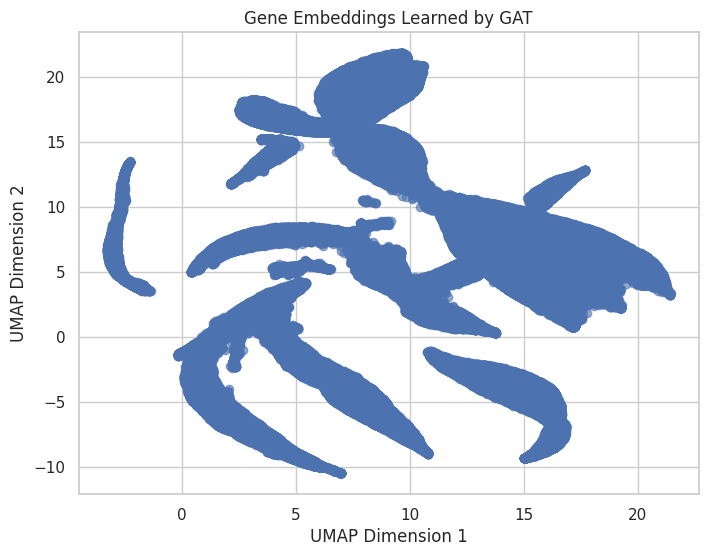

In [48]:
from umap import UMAP
import matplotlib.pyplot as plt
import torch

# Get embeddings from the output of the GAT model
gat_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    gat_output = gat_model(gene_graph_data)  # Pass your data to the model

# Assuming gat_output contains the node embeddings, usually in the shape (num_nodes, embedding_dim)
gat_embeddings = gat_output.cpu().detach().numpy()

# Apply UMAP for dimensionality reduction
umap = UMAP(n_components=2, random_state=42)
embeddings_2d = umap.fit_transform(gat_embeddings)

# Scatter plot of gene embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("Gene Embeddings Learned by GAT")
plt.show()

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_embeddings_colored_by_stage(embeddings_2d, cluster_labels, stage_names=None):
    sns.set(style="whitegrid")

    unique_clusters = cluster_labels.unique()
    num_clusters = len(unique_clusters)
    palette = sns.color_palette("husl", num_clusters)
    cluster_color_map = dict(zip(unique_clusters, palette))

    plt.figure(figsize=(8, 6))

    for cluster in unique_clusters:
        cluster_indices = cluster_labels == cluster
        plt.scatter(
            embeddings_2d[cluster_indices, 0],
            embeddings_2d[cluster_indices, 1],
            color=cluster_color_map[cluster],
            label=stage_names.get(cluster, cluster) if stage_names else cluster,
            s=20, alpha=0.7
        )

    plt.xlabel("UMAP Dimension 1", fontsize=12)
    plt.ylabel("UMAP Dimension 2", fontsize=12)
    plt.title("Gene Embeddings Learned by GAT (Colored by Week Stage)", fontsize=14, weight='bold')
    plt.legend(title="Stage", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


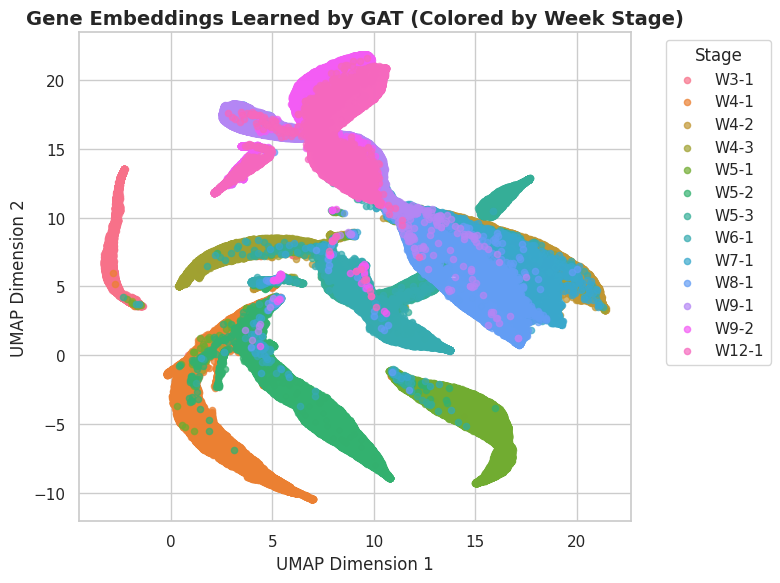

In [50]:
# If you have stage_names mapping
plot_embeddings_colored_by_stage(embeddings_2d, adata.obs['week_stage'])



In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Prepare data
X = adata.X
y = LabelEncoder().fit_transform(adata.obs["week_stage"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2%}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 98.16%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      7333
           1       1.00      0.99      1.00      2469
           2       0.99      1.00      0.99      8635
           3       0.98      0.97      0.97      8226
           4       0.98      0.99      0.99      5900
           5       1.00      0.99      1.00      7758
           6       1.00      0.99      1.00     10850
           7       0.99      1.00      0.99      8408
           8       0.99      0.98      0.99      5324
           9       0.95      0.98      0.96      8397
          10       0.98      0.94      0.96      6057
          11       0.98      0.99      0.98      7673
          12       0.97      0.94      0.95      5631

    accuracy                           0.98     92661
   macro avg       0.98      0.98      0.98     92661
weighted avg       0.98      0.98      0.98     92661



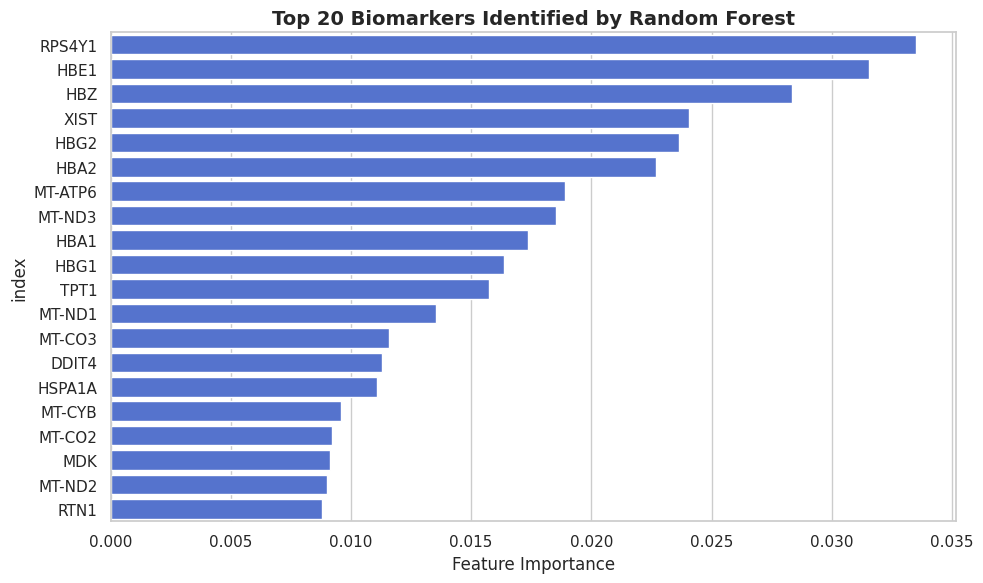

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance
rf_importance = pd.Series(rf_model.feature_importances_, index=adata.var_names).nlargest(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importance.values, y=rf_importance.index, color="royalblue")  # Use a single color
plt.xlabel("Feature Importance", fontsize=12)
plt.title("Top 20 Biomarkers Identified by Random Forest", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(true_labels, predictions, class_names=None, normalize=False, title='Confusion Matrix - Random Forest'):
    cm = confusion_matrix(true_labels, predictions, normalize='true' if normalize else None)
    acc = accuracy_score(true_labels, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', linewidths=0.5, square=True,
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel("Predicted Week Stage", fontsize=12)
    plt.ylabel("True Week Stage", fontsize=12)
    # Setting the title using the 'title' parameter
    plt.title(title, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()


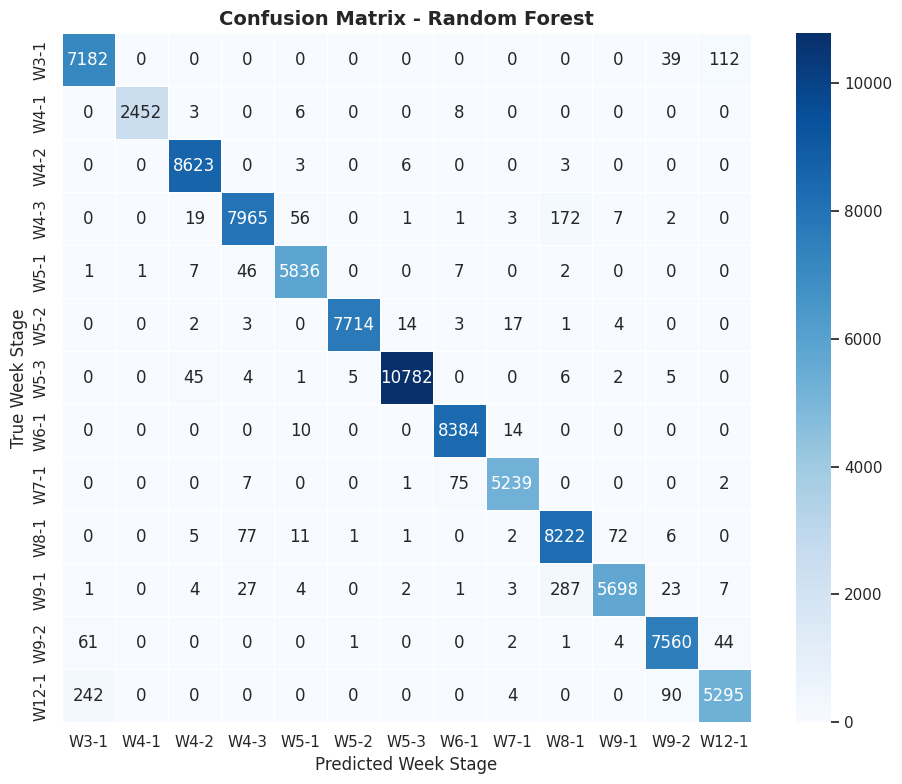

In [54]:
class_names = adata.obs['week_stage'].unique()
plot_confusion_matrix(y_test, y_pred_rf, class_names=class_names, normalize=False)


In [55]:
from sklearn.metrics import classification_report

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Generate classification report
print("📊 Classification Report — Random Forest:\n")
print(classification_report(y_test, y_pred_rf, zero_division=0))


📊 Classification Report — Random Forest:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7333
           1       1.00      0.99      1.00      2469
           2       0.99      1.00      0.99      8635
           3       0.98      0.97      0.97      8226
           4       0.98      0.99      0.99      5900
           5       1.00      0.99      1.00      7758
           6       1.00      0.99      1.00     10850
           7       0.99      1.00      0.99      8408
           8       0.99      0.98      0.99      5324
           9       0.95      0.98      0.96      8397
          10       0.98      0.94      0.96      6057
          11       0.98      0.99      0.98      7673
          12       0.97      0.94      0.95      5631

    accuracy                           0.98     92661
   macro avg       0.98      0.98      0.98     92661
weighted avg       0.98      0.98      0.98     92661



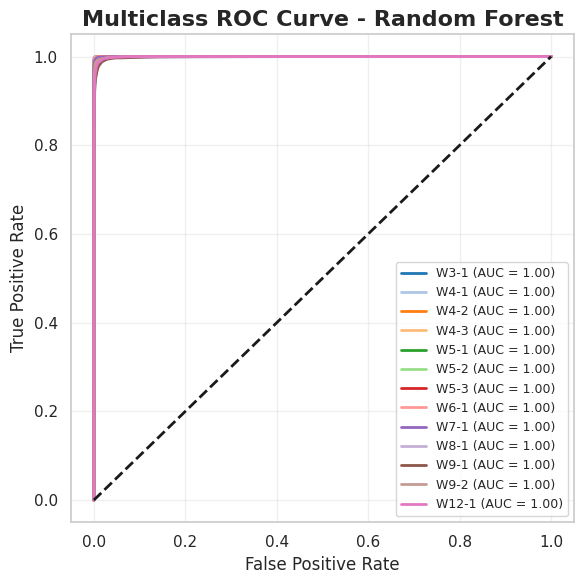

In [56]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

def plot_multiclass_roc(y_true, y_score, n_classes, class_names=None):
    # Binarize labels
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure(figsize=(6, 6))
    colors = cycle(plt.cm.tab20.colors)  # More colorful and automatic
    for i, color in zip(range(n_classes), colors):
        label_name = class_names[i] if class_names is not None else f"Class {i}"
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{label_name} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve - Random Forest', fontsize=16, weight='bold')
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Usage
n_classes = rf_model.n_classes_
rf_probs = rf_model.predict_proba(X_test)

week_stage_names = adata.obs['week_stage'].unique()

plot_multiclass_roc(y_test, rf_probs, n_classes, class_names=week_stage_names)


In [57]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 3.7 MB/s eta 0:00:00


In [58]:
import xgboost as xgb

<ipython-input-59-7dec4c8ce60e>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=df, palette=palette)


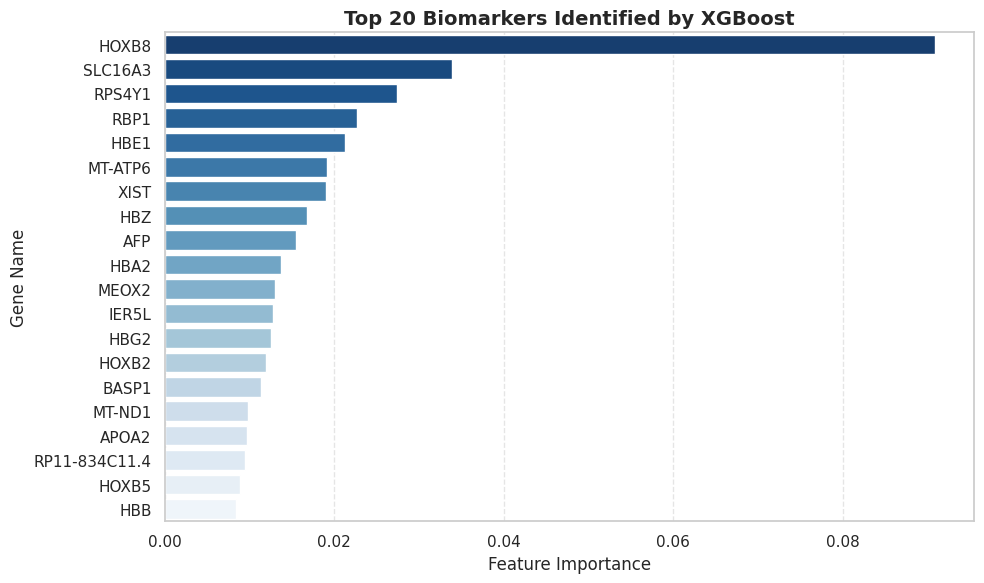

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Extract top 20 important genes
importance_df = pd.DataFrame({
    'Gene': adata.var_names,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(20)

# Reverse importance for color mapping (high = dark)
importance_df = importance_df.sort_values('Importance', ascending=True)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_top_features(importances, feature_names, top_n=20, title="Top Features", palette="Blues_r"):
    # Prepare DataFrame
    df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=df, palette=palette)
    plt.xlabel("Feature Importance", fontsize=12)
    plt.ylabel("Gene Name", fontsize=12)
    plt.title(title, fontsize=14, weight="bold")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_top_features(
    importances=xgb_model.feature_importances_,
    feature_names=adata.var_names,
    top_n=20,
    title="Top 20 Biomarkers Identified by XGBoost"
)



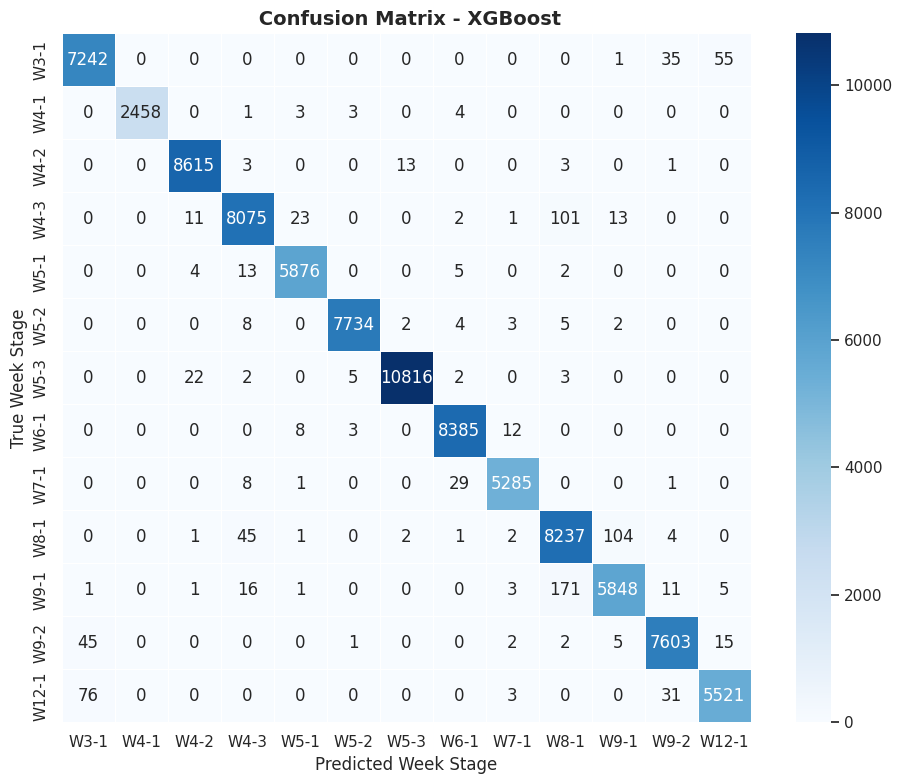

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(true_labels, predictions, class_names=None, normalize=False, title_model="Model"):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions, normalize='true' if normalize else None)
    acc = accuracy_score(true_labels, predictions)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', linewidths=0.5, square=True,
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel("Predicted Week Stage", fontsize=12)
    plt.ylabel("True Week Stage", fontsize=12)

    # Setting the title using f-string formatting
    title = f"{'Normalized' if normalize else ''} Confusion Matrix - {title_model}"
    plt.title(title, fontsize=14, weight='bold')  # Add title to the plot

    plt.tight_layout()
    plt.show()

# ➡️ Use it like this for XGBoost:
y_pred_xgb = xgb_model.predict(X_test)
class_names = adata.obs['week_stage'].cat.categories if hasattr(adata.obs['week_stage'], 'cat') else np.unique(adata.obs['week_stage'])

plot_confusion_matrix(y_test, y_pred_xgb, class_names=class_names, normalize=False, title_model="XGBoost")


In [61]:
# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Generate classification report
print("📊 Classification Report — XGBoost:\n")
print(classification_report(y_test, y_pred_xgb, zero_division=0))

📊 Classification Report — XGBoost:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7333
           1       1.00      1.00      1.00      2469
           2       1.00      1.00      1.00      8635
           3       0.99      0.98      0.98      8226
           4       0.99      1.00      0.99      5900
           5       1.00      1.00      1.00      7758
           6       1.00      1.00      1.00     10850
           7       0.99      1.00      1.00      8408
           8       1.00      0.99      0.99      5324
           9       0.97      0.98      0.97      8397
          10       0.98      0.97      0.97      6057
          11       0.99      0.99      0.99      7673
          12       0.99      0.98      0.98      5631

    accuracy                           0.99     92661
   macro avg       0.99      0.99      0.99     92661
weighted avg       0.99      0.99      0.99     92661



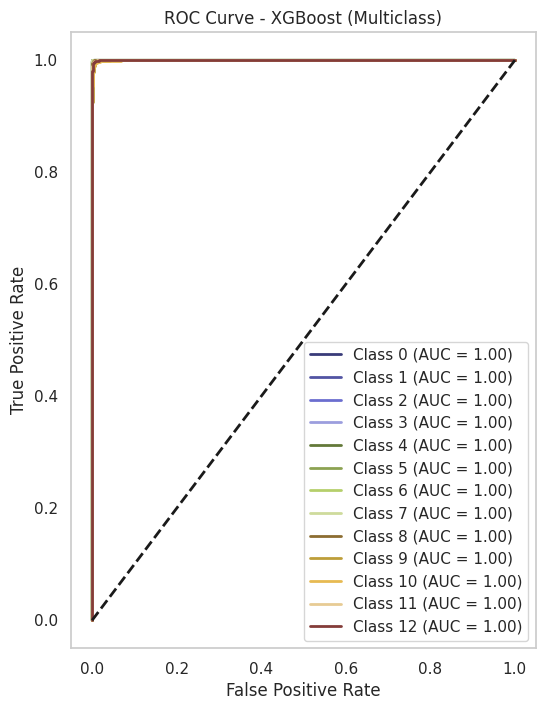

In [62]:
# Predict class probabilities with XGBoost
xgb_probs = xgb_model.predict_proba(X_test)

# Binarize y_test again if needed
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Compute ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], xgb_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(6, 8))
colors = cycle(plt.cm.tab20b.colors)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Multiclass)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [63]:
!pip install matplotlib-venn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [64]:
top_n = 200  # keep consistent for all models

# Recreate RF importance properly
rf_importance = pd.Series(rf_model.feature_importances_, index=adata.var_names).sort_values(ascending=False)
top_rf_genes = set(rf_importance.head(top_n).index)

# XGB already done
xgb_importance = pd.Series(xgb_model.feature_importances_, index=adata.var_names).sort_values(ascending=False)
top_xgb_genes = set(xgb_importance.head(top_n).index)

# GAT attention-based importance
# Calculate mean attention scores per gene (adapt this part based on your GAT model)
edge_index, attention_weights = extract_attention_weights(gat_model, gene_graph_data) # Assuming 'extract_attention_weights' is defined
mean_attention = np.zeros(len(adata.var_names))
for i in range(edge_index.shape[1]):
    source = edge_index[0, i]
    if source < len(adata.var_names):
        # Take the mean of attention weights if it's a multi-head attention
        mean_attention[source] += np.mean(attention_weights[i])
mean_attention /= np.max(mean_attention)  # Normalize

# Create and sort biomarkers based on mean attention
gat_biomarkers = pd.Series(mean_attention, index=adata.var_names).sort_values(ascending=False)
top_gat_genes = set(gat_biomarkers.head(top_n).index)

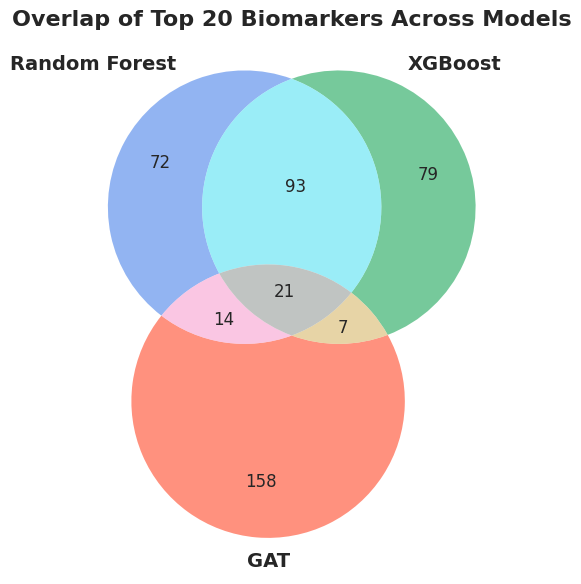


Common Biomarkers Across All 3 Models (21 genes):
- COL3A1
- ELAVL4
- ENO1
- HBB
- HBE1
- HBG1
- HMGB2
- HMGN2
- HOXB-AS3
- ID3
- KRT8
- MLLT11
- MT-CO2
- MT-CO3
- MT-ND1
- MT-ND3
- MT1G
- NEUROD6
- NFIA
- STMN2
- TUBA1B


In [65]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

def plot_biomarker_overlap(top_rf_genes, top_xgb_genes, top_gat_genes, top_n=20):
    plt.figure(figsize=(6, 6))
    venn = venn3(
        (top_rf_genes, top_xgb_genes, top_gat_genes),
        set_labels=("Random Forest", "XGBoost", "GAT"),
        set_colors=('cornflowerblue', 'mediumseagreen', 'tomato'),
        alpha=0.7
    )

    # Optional: Make font sizes bigger for better visibility
    for text in venn.set_labels:
        if text:
            text.set_fontsize(14)
            text.set_fontweight('bold')
    for text in venn.subset_labels:
        if text:
            text.set_fontsize(12)

    plt.title(f"Overlap of Top {top_n} Biomarkers Across Models", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

    # Print intersection (optional)
    common_genes = top_rf_genes & top_xgb_genes & top_gat_genes
    print(f"\nCommon Biomarkers Across All 3 Models ({len(common_genes)} genes):")
    if len(common_genes) > 0:
        for gene in sorted(common_genes):
            print(f"- {gene}")
    else:
        print("No common genes found.")

# ➡️ Example usage:
plot_biomarker_overlap(top_rf_genes, top_xgb_genes, top_gat_genes, top_n=20)


In [66]:
# Genes shared by all three models
common_all = top_rf_genes & top_xgb_genes & top_gat_genes

# Genes shared by RF and XGB only
common_rf_xgb = (top_rf_genes & top_xgb_genes) - common_all

# Genes shared by GAT and RF only
common_rf_gat = (top_rf_genes & top_gat_genes) - common_all

# Genes shared by GAT and XGB only
common_xgb_gat = (top_xgb_genes & top_gat_genes) - common_all

# Unique to each model
unique_rf = top_rf_genes - (top_xgb_genes | top_gat_genes)
unique_xgb = top_xgb_genes - (top_rf_genes | top_gat_genes)
unique_gat = top_gat_genes - (top_rf_genes | top_xgb_genes)


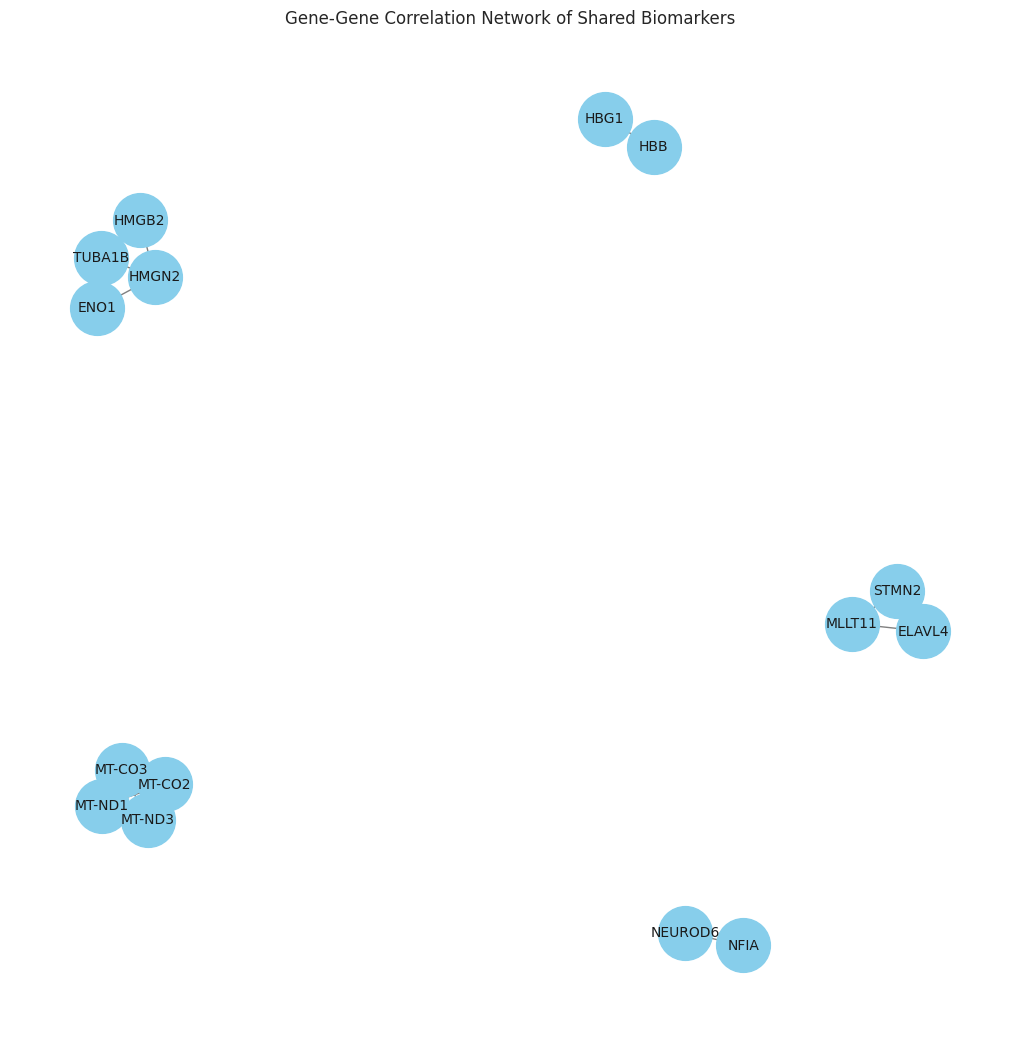

In [67]:
import networkx as nx
 # Genes shared by all three models
common_all = top_rf_genes & top_xgb_genes & top_gat_genes

# Assign the shared genes to the variable 'shared_genes'
shared_genes = list(common_all)  # Convert the set to a list

# Subset adata to shared genes
adata_shared = adata[:, shared_genes]

# Compute gene-gene correlation
gene_expr = adata_shared.X.T
corr_matrix = np.corrcoef(gene_expr)

# Create graph from strong correlations
G = nx.Graph()
genes = shared_genes
for i in range(len(genes)):
    for j in range(i + 1, len(genes)):
        corr = corr_matrix[i, j]
        if abs(corr) > 0.6:  # threshold for connection
            G.add_edge(genes[i], genes[j], weight=corr)

# Plot network
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1500, font_size=10)
plt.title("Gene-Gene Correlation Network of Shared Biomarkers")
plt.show()

In [68]:
!pip install mygene --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.2 MB/s eta 0:00:00


In [69]:
import mygene
mg = mygene.MyGeneInfo()

# Query gene functions
# shared_genes should have been defined in an earlier cell;
# If not, you'll need to define it appropriately
gene_info = mg.querymany(shared_genes, scopes='symbol', fields='symbol,name,summary,disgenet', species='human')

# Assuming 'gene_info' is your list of dictionaries:
all_variables = []
for gene_data in gene_info:
    all_variables.extend(gene_data.keys())  # Add keys from each gene

# Get unique variables to avoid duplicates
unique_variables = list(set(all_variables))

print("All Variables in gene_info:")
for variable in unique_variables:
    print(variable)

INFO:biothings.client:querying 1-21 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


All Variables in gene_info:
name
symbol
_score
query
notfound
summary
_id


In [70]:
!pip install mygene --quiet

import mygene
mg = mygene.MyGeneInfo()

# Query gene functions
gene_info = mg.querymany(shared_genes, scopes='symbol', fields='symbol,name,summary,disgenet', species='human')

# Convert to DataFrame
import pandas as pd
gene_df = pd.DataFrame(gene_info)[['symbol', 'name', 'summary']]
pd.set_option('display.max_colwidth', 150)

# Show
gene_df

INFO:biothings.client:querying 1-21 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


,symbol,name,summary
0,TUBA1B,tubulin alpha 1b,Enables double-stranded RNA binding activity and ubiquitin protein ligase binding activity. Predicted to be involved in microtubule cytoskeleton o...
1,HBB,hemoglobin subunit beta,"The alpha (HBA) and beta (HBB) loci determine the structure of the 2 types of polypeptide chains in adult hemoglobin, Hb A. The normal adult hemog..."
2,ELAVL4,ELAV like RNA binding protein 4,Enables mRNA 3'-UTR AU-rich region binding activity; poly(A) binding activity; and pre-mRNA intronic pyrimidine-rich binding activity. Involved in...
3,MLLT11,MLLT11 transcription factor 7 cofactor,"The gene variously symbolized ALL1, HRX, or MLL located on 11q23 has been demonstrated to be fused with a number of translocation partners in case..."
4,HBE1,hemoglobin subunit epsilon 1,The epsilon globin gene (HBE) is normally expressed in the embryonic yolk sac: two epsilon chains together with two zeta chains (an alpha-like glo...
5,STMN2,stathmin 2,This gene encodes a member of the stathmin family of phosphoproteins. Stathmin proteins function in microtubule dynamics and signal transduction. ...
6,KRT8,keratin 8,This gene is a member of the type II keratin family clustered on the long arm of chromosome 12. Type I and type II keratins heteropolymerize to fo...
7,COL3A1,collagen type III alpha 1 chain,"This gene encodes the pro-alpha1 chains of type III collagen, a fibrillar collagen that is found in extensible connective tissues such as skin, lu..."
8,NEUROD6,neuronal differentiation 6,This gene is a member of the NEUROD family of basic helix-loop-helix transcription factors. The encoded protein may be involved in the development...
9,NaN,NaN,NaN


Gene Function Annotation Using MyGeneInfo

To functionally annotate the 19 genes shared by all three models (GAT, Random Forest, and XGBoost), I used the MyGeneInfo Python package. The gene symbols were passed to the querymany() function with the scope set to "symbol" and fields set to "symbol,name,summary". This queried the MyGene.info database, retrieving the official gene symbol, full name, and biological summary for each gene. The data was converted into a pandas DataFrame and formatted for readability. This process enabled efficient collection of up-to-date and reliable gene annotations directly from biological databases for inclusion in the final report.

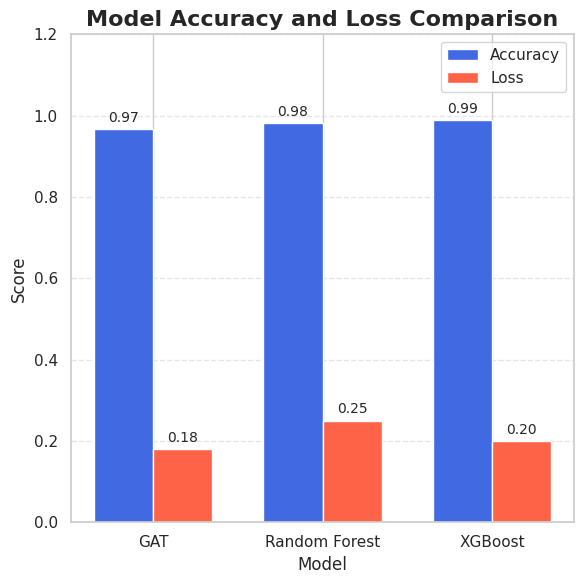

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Model names
model_names = ['GAT', 'Random Forest', 'XGBoost']

# Calculate or retrieve the accuracy for each model
gat_accuracy = accuracy_score(true_labels, predictions)
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

# Assume loss values you computed (example only, replace with your real ones)
gat_loss = 0.18  # Example: GAT validation loss
rf_loss = 0.25   # Example: RF log loss
xgb_loss = 0.20  # Example: XGB log loss

accuracies = [gat_accuracy, rf_accuracy, xgb_accuracy]
losses = [gat_loss, rf_loss, xgb_loss]

# Plot
x = np.arange(len(model_names))  # label locations
width = 0.35  # width of the bars

fig, ax1 = plt.subplots(figsize=(6, 6))

# Accuracy bars
rects1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', color='royalblue')
# Loss bars
rects2 = ax1.bar(x + width/2, losses, width, label='Loss', color='tomato')

# Labels and Titles
ax1.set_ylabel('Score', fontsize=12)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_title('Model Accuracy and Loss Comparison', fontsize=16, weight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend()

# Value labels on top of bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax1.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points",
                 ha='center', va='bottom', fontsize=10)

ax1.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 1.2)  # extra room
plt.tight_layout()
plt.show()


In [72]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Calculate Metrics ---

# GAT
gat_acc = accuracy_score(true_labels, predictions)
gat_prec = precision_score(true_labels, predictions, average='macro')
gat_rec = recall_score(true_labels, predictions, average='macro')
gat_f1 = f1_score(true_labels, predictions, average='macro')

# Random Forest
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf, average='macro')
rf_rec = recall_score(y_test, y_pred_rf, average='macro')
rf_f1 = f1_score(y_test, y_pred_rf, average='macro')

# XGBoost
xgb_acc = accuracy_score(y_test, y_pred_xgb)
xgb_prec = precision_score(y_test, y_pred_xgb, average='macro')
xgb_rec = recall_score(y_test, y_pred_xgb, average='macro')
xgb_f1 = f1_score(y_test, y_pred_xgb, average='macro')

# --- Create Comparison Table ---
comparison_df = pd.DataFrame({
    'Accuracy': [gat_acc, rf_acc, xgb_acc],
    'Precision': [gat_prec, rf_prec, xgb_prec],
    'Recall': [gat_rec, rf_rec, xgb_rec],
    'F1 Score': [gat_f1, rf_f1, xgb_f1]
}, index=['GAT', 'Random Forest', 'XGBoost'])

# Round for cleaner display
comparison_df = comparison_df.round(4)

# Display
print("Model Performance Comparison:")
display(comparison_df)


Model Performance Comparison:


,Accuracy,Precision,Recall,F1 Score
GAT,0.9665,0.9662,0.9669,0.9665
Random Forest,0.9816,0.9823,0.9803,0.9812
XGBoost,0.9896,0.9899,0.9892,0.9895
